# Crimson Stimulation Responses

Looking through the BrainPatch stimulation responses, in particular those LFP/dendritic spikes. Need to figure out what they are...

From the "artifact_exploration" stuff I was doing, it looks like I'll mostly need to look at clips around the stim. Can probably HPF at about 70 hz and keep the interesting stuff

In [1]:
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import pandas as pd
from open_ephys.analysis import Session
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.signal.windows import gaussian
from sklearn.decomposition import PCA
import os

import re

%matplotlib ipympl

## Define a few functions for later usage

First one just opens an open ephys directory and returns the signals, timestamps, and events

In [2]:
def open_sig_events(directory:str):
    # open up a session, then pull out the signal and events
    session = Session(directory)

    recording = session.recordnodes[0].recordings[0].continuous[0]

    # get out the signal
    sig = recording.samples[:,:64] * recording.metadata['bit_volts'][0]

    # pull out the events -- both giving the time and the indices
    events = np.argwhere(np.diff(recording.samples[:,64]>5000) == 1)
    events = events.reshape([int(events.shape[0]/2),2])
    event_ts = events/recording.metadata['sample_rate']

    # timestamps
    timestamps = recording.sample_numbers - recording.sample_numbers[0]
    timestamps = timestamps/recording.metadata['sample_rate']

    return sig, timestamps, events, event_ts


Function to find the minimum of a clipped period after the stimulation

In [3]:
def find_responses(sig, events, len_ms:int = 25, n_chans:int = 64, sample_rate:int = 30000):

    t_len = len_ms*30 # 52 ms * 30 khz

    # set up the events to plot patches
    n_events = events.shape[0] # number of stimulation events

    responses = np.zeros((n_events, t_len, n_chans))
    # maxs = np.zeros((n_events, n_chans)) # not getting much info from these
    # rel_maxs = np.zeros((n_events, n_chans))
    # abs_maxs = np.zeros((n_events, n_chans))
    mins = np.zeros((n_events, n_chans))
    rel_mins = np.zeros((n_events, n_chans))
    abs_mins = np.zeros((n_events, n_chans))

    for i_event, event in enumerate(events):
        response = sig[event[0]:event[0]+len_ms*int(sample_rate/1000),:]
        means = np.mean(sig[event[0]+4:event[1]-4,:], axis = 0)
        responses[i_event,:,:] = response - means # response for each channel
    
        mins[i_event,:] = np.min(response - means, axis=0)
        rel_mins[i_event,:] = np.argmin(response - means, axis=0)/30000
        abs_mins[i_event,:] = rel_mins[i_event,:] + event_ts[i_event,0]

    return mins, rel_mins, abs_mins

Plot the average post-stim responses for a particular channel. Will plot it into an existing axis if provided one

In [4]:
def plot_avg_response(sig, events, len_ms:int = 25, channel = 0, ax:plt.axes=None, label:str=None):
    # Plot the average response for a particular channel
    
    if ax is None:
        fig,ax = plt.subplots()
    
    if label == None:
        label = f'Channel {channel}'


    # set up the events to plot patches
    n_events = events.shape[0] # number of stimulation events

    # put together a NxT array
    t_len = len_ms * 30
    responses = np.zeros((n_events, t_len))
    
    # go through each event
    for i_event, event in enumerate(events):
        response = sig[event[0]:event[0]+len_ms*30,channel]
        means = np.mean(sig[event[0]+4:event[1]-4]) # center the during-stimulation to 0
        responses[i_event,:] = response - means
    
    # put together the means, STDs, and timestamps
    ts = np.arange(t_len)/30
    means = np.mean(responses, axis=0)
    line = ax.plot(ts, means, label=label)
    
    ts_std = np.ravel(np.array([ts, ts[::-1]]))
    std = np.ravel(np.array([means + np.std(responses, axis=0), means[::-1] - np.std(responses, axis=0)[::-1]]))
    patch_array = np.array([ts_std, std]).T
    std_patch = Polygon(patch_array, alpha=0.2, color=line[-1].get_color())
    ax.add_patch(std_patch)

    # print(dir(line))

Find spikes using the old-school default:

1. Filter and de-mean
1. Calculate a threshold: -4.5x the STD
1. Flag issues:
    1. Too-short ISIs (< 3 ms?)
    1. Simulataneous-ish (on more than N channels)
    1. Something about the wave shape -- deviations? Depth of field?
1. 


In [12]:
def find_spikes(sig, filter_high:float = 6000, filter_low:float = 300, sample_rate:int = 30000, CAR:bool = True):
    # number of channels
    n_chan = np.min(sig.shape)
    axis = np.argmax(sig.shape)
    sig = sig.T if axis == 1 else sig # make sure that Time is along axis 0

    # # CAR
    # if CAR:
    #     pca = PCA()
    #     xform = PCA.fit_transform(sig)
    #     # sig = np.matmul(xform, PCA.)


    # filter the thing
    sos = signal.butter(N=8, Wn=[filter_low, filter_high], fs=sample_rate, output='sos', btype='bandpass')
    filt_sig = signal.sosfiltfilt(sos=sos, x=sig, axis=0)

    # find a threshold for each channel
    thresholds = np.expand_dims(-4.5 * np.std(filt_sig, axis=0), axis=0)


    # find the crossings
    thresholds_rep = np.tile(thresholds, (np.max(sig.shape), 1)) # create a TxN array of N threshold values
    crossings = np.argwhere(np.diff((filt_sig<thresholds_rep).astype(int), axis=0) > 0)

    # Create a dataframe for the spikes, and also store chunks of 50 ms of data
    spike_df = pd.DataFrame({'sample_no':crossings[:,0].astype(int), 'electrode':crossings[:,1].astype(int)})
    sample_columns = [f'sample {i - 10}' for i in range(50)]
    spike_df.loc[:,sample_columns] = np.nan

    for i_row,row in spike_df.iterrows():
        spike_df.loc[i_row,sample_columns] = filt_sig[np.arange(start=int(row['sample_no'])-10, stop=int(row['sample_no'])+40),int(row['electrode'])]

    return spike_df, filt_sig






## Single file analysis

Mostly to check the functioning of the code when I'm batch processing files

pull in the data -- we'll start with one file at a time

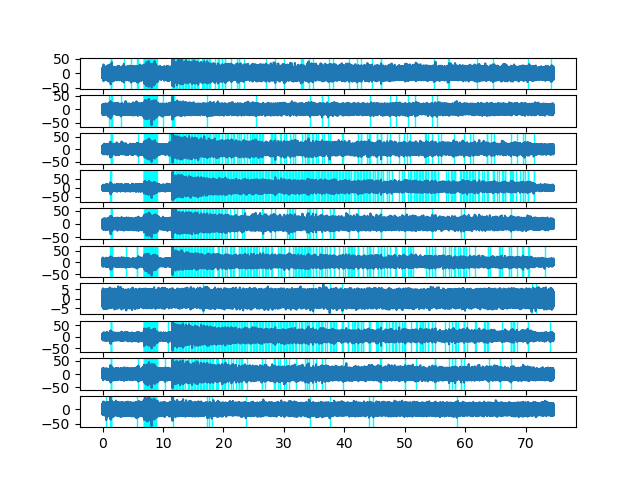

In [13]:
directory = 'Z:\\BrainPatch\\20240821\\Crimson__2024-08-21_15-10-03__20mA_MinOil_2ms'

# load signals if we haven't already loaded it
if 'sig' not in locals():
    sig, timestamps, events, event_ts = open_sig_events(directory)

# pull out the spikes
if 'spike_df' not in locals():
    spike_df,filt_sig = find_spikes(sig)

# choose the channels to show
channels = np.arange(40,50)

# plot the continuous and show the times
fig_cont, ax_cont = plt.subplots(nrows = len(channels), sharex=True)

for i_channel, channel in enumerate(channels):
    ax_cont[i_channel].plot(timestamps, filt_sig[:,channel])
    for i_spike, spike in spike_df.loc[spike_df['electrode'] == channel].iterrows():
        ax_cont[i_channel].axvspan((int(spike['sample_no'])-10)/30000, (int(spike['sample_no'])+40)/30000, color = 'cyan')
    


In [9]:
col_names = [f'sample {i-10}' for i in range(50)]
means = spike_df.groupby('electrode').mean()
ts = np.arange(-10,40)/30
for i_plot in range(4):
    ax.plot(ts, means.loc[i_plot, col_names])

ax.label('')



# spike_df.groupby('electrode').mean()

In [14]:
pca = PCA()

sig_comp = pca.fit_transform(sig)


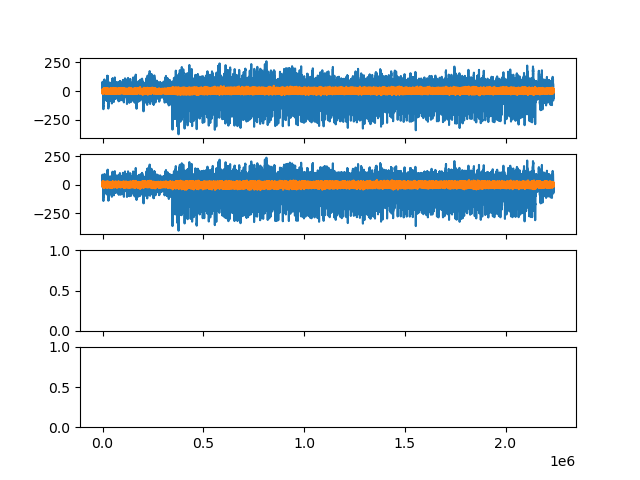

In [27]:
fig_pca, ax_pca = plt.subplots(nrows=4, sharex=True)

sos = signal.butter(N = 12, Wn=[300, 6000], fs=30000, btype= 'bandpass', output='sos')
sig_filt = signal.sosfiltfilt(sos = sos, x = sig, axis=0)

ax_pca[0].plot(sig[:,0])
ax_pca[0].plot(np.matmul(sig_comp[:,2:], pca.components_[2:,:])[:,0])
ax_pca[1].plot(sig[:,60])
ax_pca[1].plot(np.matmul(sig_comp[:,2:], pca.components_[2:,:])[:,60])




In [ ]:
# directory = 'Z:\\BrainPatch\\20240821\\Crimson__2024-08-21_13-29-59__20mA_MinOil_2ms'
# directory = 'Z:\\BrainPatch\\20240821\\Crimson__2024-08-21_13-46-01__20mA_MinOil_2ms'
directory = 'Z:\\BrainPatch\\20240821\\Crimson__2024-08-21_15-10-03__20mA_MinOil_2ms'
session = Session(directory)
print(session)


for i_rec in range(len(session.recordnodes)):
    print(f'{len(session.recordnodes[i_rec].recordings)} recording(s) in session "{session.recordnodes[i_rec].directory}"\n')
    recordings = session.recordnodes[i_rec].recordings
    
    for i_rec,recording in enumerate(recordings):
        recording.load_continuous()
        recording.load_spikes()
        recording.load_events()
        recording.load_messages()

        print(f'Recording {i_rec} has:')
        print(f'\t{len(recording.continuous)} continuous streams')
        print(f'\t{len(recording.spikes)} spike streams')
        print(f'\t{len(recording.events)} event streams')
    
    print('\n')


See if we can filter out some of the respiratory noise

In [7]:
sig = session.recordnodes[0].recordings[0].continuous[0].samples[:,:64]
stim = session.recordnodes[0].recordings[0].continuous[0].samples[:,64]

sos_h = signal.butter(N = 8, Wn = [300], btype='high', output = 'sos', fs=30000)
sos_l = signal.butter(N = 8, Wn = [6000], btype='low', output = 'sos', fs=30000)
sig_hpf = signal.sosfiltfilt(sos_h, sig, axis=0)
sig_lpf = signal.sosfiltfilt(sos_l, sig, axis=0)
# fs,mag = signal.sosfreqz(sos_l, fs=30000, worN=1024)

# fig_filt, ax_filt = plt.subplots()

# ax_filt.semilogx(fs,np.abs(mag))

In [ ]:
fig,ax = plt.subplots()

timestamps = recording.continuous[0].sample_numbers - recording.continuous[0].sample_numbers[0]
timestamps = timestamps/recording.continuous[0].metadata['sample_rate']

# ax.loglog(fs,np.abs(mag))
# ax.plot(timestamps, sig_hpf[:,0])
# ax.plot(timestamps, sig_lpf[:,0])
# ax.plot(timestamps, sig[:,0])
ax.plot(sig_hpf[:,0])
ax.plot(sig_lpf[:,0])
ax.plot(sig[:,0])

ax.legend(['hpf','lpf','no filt'])

# set up the events to plot patches
events = np.argwhere(np.diff(recording.continuous[0].samples[:,64]>5000) == 1)
events = events.reshape([int(events.shape[0]/2),2])
event_ts = events/recording.continuous[0].metadata['sample_rate']

# plot the event times
for i_event,event in enumerate(event_ts):
    # print(f'{i_event}:{event}')
    ax.axvspan(event[0], event[1], color='k', alpha=.1)

In [ ]:
np.any(np.diff(recording.continuous[0].sample_numbers) != 1)

In [ ]:
plt.close('all')

Grab 50 ms after each stimulation. Set the mean of the stimulation period to 0.

Find the minimum, maximum, depth of modulation, and time of each after the stimulation starts

In [12]:
n_chans = 64 # 64 recording channels
len_ms = 150
t_len = len_ms*30 # 52 ms * 30 khz
n_events = events.shape[0] # number of stimulation events

# set up the events to plot patches
events = np.argwhere(np.diff(recording.continuous[0].samples[:,64]>5000) == 1)
events = events.reshape([int(events.shape[0]/2),2])
event_ts = events/recording.continuous[0].metadata['sample_rate']

responses = np.zeros((n_events, t_len, n_chans))
maxs = np.zeros((n_events, n_chans))
rel_maxs = np.zeros((n_events, n_chans))
abs_maxs = np.zeros((n_events, n_chans))
mins = np.zeros((n_events, n_chans))
rel_mins = np.zeros((n_events, n_chans))
abs_mins = np.zeros((n_events, n_chans))

for i_event, event in enumerate(events):
    response = sig[event[0]:event[0]+len_ms*30,:]
    means = np.mean(sig[event[0]+4:event[1]-4,:], axis = 0)
    responses[i_event,:,:] = response - means # response for each channel
    
    mins[i_event,:] = np.min(response - means, axis=0)
    rel_mins[i_event,:] = np.argmin(response - means, axis=0)/30000
    abs_mins[i_event,:] = rel_mins[i_event,:] + event_ts[i_event,0]

    # maxs[i_event,:] = np.max(response[int(rel_mins*30000),:] - means, axis=0) # only interested in stuff after the negative deviation
    # rel_maxs[i_event,:] = np.argmax(response[int(rel_mins*30000),:] - means, axis=0)/30000
    # abs_maxs[i_event,:] = rel_maxs[i_event,:] + event_ts[i_event,0]


Now let's do the same thing, but look at the same channel for a couple of different stimulation amplitudes

In [ ]:
fig_time, ax_time = plt.subplots()

ax_time.plot(np.diff(timestamps))

In [ ]:
plt_chans = [30, 31, 32, 33]
n_plt = len(plt_chans)

fig_comb,ax_comb = plt.subplots(nrows=n_plt, sharex=True, sharey = True)

# put together the timestamps
timestamps = recording.continuous[0].sample_numbers - recording.continuous[0].sample_numbers[0]
timestamps = timestamps/recording.continuous[0].metadata['sample_rate']

for i_chan, chan in enumerate(plt_chans):
    ax_comb[i_chan].plot(timestamps, sig_filt[:,i_chan])

    # plot the event times and max and min points
    for i_event,event in enumerate(event_ts):
        # print(f'{i_event}:{event}')
        ax_comb[i_chan].axvspan(event[0], event[1], color='k', alpha=.1)
        ax_comb[i_chan].scatter(abs_maxs[i_event, i_chan], maxs[i_event, i_chan], 2, color='r')
        ax_comb[i_chan].scatter(abs_mins[i_event, i_chan], mins[i_event, i_chan], 2, color='cyan')





### Average stimulation responses

let's take a look at the average stimulation response for a couple different electrodes

In [ ]:
# directory = 'Z:\\BrainPatch\\20240821\\Crimson__2024-08-21_13-46-01__20mA_MinOil_2ms'
directory = 'Z:\\BrainPatch\\20240821\\Crimson__2024-08-21_13-29-59__20mA_MinOil_2ms'

# get the signal etc
signal, timestamps, events, event_ts = open_sig_events(directory)

fig_avg, ax_avg = plt.subplots()

for channel in [0,5,10,15,20]:
    plot_avg_response(signal, events, len_ms= 40, channel=channel, ax=ax_avg)


ax_avg.axvspan(0, 2, color='k', alpha=.1, label='Stimulation Period')

# clean up the plot, add a legend etc
ax_avg.legend()
for spine in ['top','bottom','right','left']:
    ax_avg.spines[spine].set_visible(False)

ax_avg.set_xlabel('Time after stimulation onset (ms)')
ax_avg.set_ylabel('Magnitude (uV)')
ax_avg.set_title('Mean stimulation responses with standard deviations\n20 mA, 400 um')

## Multi-file analysis

Looking at the responses over different distances and currents

First we need to put together a list of the different recordings and the parameters

In [28]:
# lets go through recordings in groups of locations
base_dir = 'Z:\\BrainPatch\\20240821'

dir_400 = ['Crimson__2024-08-21_13-44-07__10mA_MinOil_2ms','Crimson__2024-08-21_13-46-01__20mA_MinOil_2ms','Crimson__2024-08-21_13-47-40__15mA_MinOil_2ms','Crimson__2024-08-21_13-49-43__10mA_MinOil_2ms','Crimson__2024-08-21_13-51-50__5mA_MinOil_2ms']
dir_700 = ['Crimson__2024-08-21_13-56-49__5mA_MinOil_2ms','Crimson__2024-08-21_13-58-50__10mA_MinOil_2ms','Crimson__2024-08-21_14-00-53__15mA_MinOil_2ms','Crimson__2024-08-21_14-02-54__20mA_MinOil_2ms']
dir_1000 = ['Crimson__2024-08-21_14-05-52__5mA_MinOil_2ms','Crimson__2024-08-21_14-07-41__10mA_MinOil_2ms','Crimson__2024-08-21_14-09-46__15mA_MinOil_2ms','Crimson__2024-08-21_14-11-45__20mA_MinOil_2ms']
dir_1300 = ['Crimson__2024-08-21_14-14-26__5mA_MinOil_2ms','Crimson__2024-08-21_14-16-02__10mA_MinOil_2ms','Crimson__2024-08-21_14-17-58__15mA_MinOil_2ms','Crimson__2024-08-21_14-20-21__20mA_MinOil_2ms']
dir_1600 = ['Crimson__2024-08-21_14-23-13__5mA_MinOil_2ms','Crimson__2024-08-21_14-25-16__10mA_MinOil_2ms','Crimson__2024-08-21_14-27-12__15mA_MinOil_2ms','Crimson__2024-08-21_14-29-03__20mA_MinOil_2ms']

# dictionary of direct groups
dir_dict = {400: dir_400, 700:dir_700, 1000:dir_1000, 1300:dir_1300, 1600:dir_1600}


Next let's take a look at a single channel for a few different current levels

In [ ]:
fig_avg_dist, ax_avg_dist = plt.subplots()

for sub_dir in dir_400:
    directory = os.path.join(base_dir,sub_dir)

    # get the signal etc
    signal, timestamps, events, event_ts = open_sig_events(directory)

    amp = re.search('(\d)+mA',sub_dir)[0]
    plot_avg_response(signal, events, len_ms= 40, channel=channel, ax=ax_avg_dist, label=amp)

ax_avg_dist.axvspan(0, 2, color='k', alpha=.1, label='Stimulation Period')
    
# clean up the plot, add a legend etc
ax_avg_dist.legend()
for spine in ['top','bottom','right','left']:
    ax_avg_dist.spines[spine].set_visible(False)

ax_avg_dist.set_xlabel('Time after stimulation onset (ms)')
ax_avg_dist.set_ylabel('Magnitude (uV)')
ax_avg_dist.set_title('Mean stimulation at different stimulation amplitudes')

Load all of the different directories, then put the mean and median negative deviation for each channel into a dataframe for easy analysis and plotting

In [ ]:
resp_df = pd.DataFrame(columns=['Channel_no','Current','Distance','uMin','uMin_ts','medMin','medMin_ts'])

for dist,dir_list in dir_dict.items():
    for sub_dir in dir_list:
        directory = os.path.join(base_dir, sub_dir)

        # open the directory
        sig, timestamps, events, event_ts = open_sig_events(directory)

        # pull out the stim responses
        mins, rel_mins, abs_mins = find_responses(sig, events)

        # means and medians for each channel
        uMins = np.mean(mins, axis=0)
        uMins_ts = np.mean(rel_mins, axis=0)
        medMins = np.median(mins, axis=0)
        medMins_ts = np.median(rel_mins, axis=0)

        # a nested dictionary of all of the channels responses
        tdict = {ii:{'Channel_no':ii, 
                'Current':re.search('([0-9]+)mA', sub_dir)[1],
                'Distance': dist,
                'uMin':uMins[ii],
                'uMin_ts':uMins_ts[ii],
                'medMin':medMins[ii],
                'medMin_ts':medMins_ts[ii],
                } for ii in range(64)}

        t_df = pd.DataFrame.from_dict(tdict, orient='index') # create a dataframe

        resp_df = pd.concat([resp_df, t_df], ignore_index=True)

resp_df.Current = resp_df.Current.astype(int)

Plot the effects of distance on the magnitude of the response for the different current levels. Different channels on different axes

In [ ]:
currents = resp_df.Current.unique()
currents.sort()
channels = [10, 15, 20, 25, 30]

fig_dist,ax_dist = plt.subplots(nrows=len(channels), sharex=True, sharey=True)
# fig_time, ax_time = plt.subplots(nrows=len(channels), sharex=True, sharey=True)
for i_chan,chan in enumerate(channels):
    for i_curr,curr in enumerate(currents):
        dist_cmp = resp_df.loc[(resp_df.Current==curr) * (resp_df.Channel_no==chan)]
        ax_dist[i_chan].plot(dist_cmp.Distance, dist_cmp.uMin)
        # ax_time[i_chan].plot(dist_cmp.Distance, dist_cmp.uMin_ts)

    ax_dist[i_chan].legend([f'{current} mA' for current in currents], loc=4)
    ax_dist[i_chan].set_title(f'Channel {chan}')
    ax_dist[i_chan].set_ylabel('Magnitude (uV)')


    # ax_time[i_chan].legend([f'{current} mA' for current in currents], loc=4)
    # ax_time[i_chan].set_title(f'Channel {chan}')
    # ax_time[i_chan].set_ylabel('Time (ms)')

    # remove the outer boxes
    for spine in ['top','bottom','right','left']:
        ax_dist[i_chan].spines[spine].set_visible(False)
        # ax_time[i_chan].spines[spine].set_visible(False)
    

ax_dist[-1].set_xlabel('Distance (um)')
fig_dist.suptitle('Mean response minimum as a function of distance (per current level)')


# ax_time[-1].set_xlabel('Distance (um)')
# fig_time.suptitle('Mean minimum time as a function of distance (per current level)')



mean negative deviation for all channels as a function of distance. Different axis per current level

In [ ]:
currents = resp_df.Current.unique()
distances = resp_df.Distance.unique()
currents.sort()
distances.sort()

fig_min_scatter,ax_min_scatter = plt.subplots(ncols=len(currents), sharex=True, sharey=True)
for i_curr,curr in enumerate(currents):
    dist_cmp = resp_df.loc[resp_df.Current==curr ]
    ax_min_scatter[i_curr].scatter(dist_cmp.Distance, dist_cmp.uMin, s = 2, color='blue')
    current_means = dist_cmp.groupby('Distance').mean('uMin')
    ax_min_scatter[i_curr].plot(current_means.index, current_means.uMin, color='k')

    # ax_min_scatter[i_curr].legend([f'{current} mA' for current in currents], loc=4)
    ax_min_scatter[i_curr].set_title(f'LED current: {curr} mA')
    ax_min_scatter[i_curr].set_xlabel('Distance (um)')


    # remove the outer boxes
    for spine in ['top','bottom','right','left']:
        ax_min_scatter[i_curr].spines[spine].set_visible(False)
        # ax_time[i_chan].spines[spine].set_visible(False)
    

ax_min_scatter[0].set_ylabel('Magnitude (uV)')
fig_dist.suptitle('Mean response minimum as a function of distance (per current level)')


# ax_time[-1].set_xlabel('Distance (um)')
# fig_time.suptitle('Mean minimum time as a function of distance (per current level)')



Time of the minimum value as a function of current. Each distance on a different plot

In [ ]:
currents = resp_df.Current.unique()
distances = resp_df.Distance.unique()
currents.sort()
distances.sort()

fig_time_scatter,ax_time_scatter = plt.subplots(ncols=len(distances), sharex=True, sharey=True)
for i_dist,dist in enumerate(distances):
    curr_cmp = resp_df.loc[resp_df.Distance == dist]
    ax_time_scatter[i_dist].scatter(curr_cmp.Current, curr_cmp.uMin_ts, s = 2, color='blue')
    curr_means = curr_cmp.groupby('Current').mean('uMin_ts')
    ax_time_scatter[i_dist].plot(curr_means.index, curr_means.uMin_ts, color='k')

    # ax_time_scatter[i_dist].legend([f'{distent} mA' for distent in distents], loc=4)
    ax_time_scatter[i_dist].set_title(f'Distance: {dist}um')
    ax_time_scatter[i_dist].set_xlabel('Current (mA)')


    # remove the outer boxes
    for spine in ['top','bottom','right','left']:
        ax_time_scatter[i_dist].spines[spine].set_visible(False)
        # ax_time[i_chan].spines[spine].set_visible(False)
    

ax_time_scatter[0].set_ylabel('Time (ms)')
fig_dist.suptitle('Mean response minimum as a function of current (per distance)')
